In [1]:
import os
import sys
sys.path.append('..')
import json
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumCircuit, QuantumRegister, transpile
from qiskit.providers.ibmq.runtime.utils import RuntimeEncoder, RuntimeDecoder
from qiskit.circuit import ParameterVector

from observables import plot_counts_with_curve
from trotter import trotter_step_circuits
from cost_sections import FitSecond, FitFirst, FitGeneral, FitSymmetric
from pnp_ansatze import make_Agate, make_pnp_ansatz
from cost_functions import global_cost_function, local_cost_function
from sequential_minimizer import SequentialVCMinimizer
from rttgen import CNOTBasedRtt, PulseEfficientCR
from cx_decomposition import cx_circuit
from model_circuits import single_step, two_steps
from observables import plot_curve, number_density

In [2]:
def make_step_circuits(num_site, aJ, am, omegadt, backend, physical_qubits):
    qubit_pairs = list(zip(range(0, num_site - 1), range(1, num_site)))
  
    if backend.configuration().simulator:
        rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
        cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
        cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)
    else:
        rtts = dict((qubits, PulseEfficientCR(backend, (physical_qubits[qubits[0]], physical_qubits[qubits[1]]))) for qubits in qubit_pairs)
        cxs = dict((qubits, cx_circuit(backend, physical_qubits[qubits[0]], physical_qubits[qubits[1]])) for qubits in qubit_pairs)
        cxs.update((qubits[::-1], cx_circuit(backend, physical_qubits[qubits[1]], physical_qubits[qubits[0]])) for qubits in qubit_pairs)

    single_step_circuit = single_step(num_site, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    two_step_circuit = two_steps(num_site, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    
    return single_step_circuit, two_step_circuit

In [3]:
num_site = 4
aJ = 1.
am = 0.5
omegadt = 0.2
# aJ = 0.7
# am = 0.439
# omegadt = 0.167
num_tstep = 6

backend = Aer.get_backend('statevector_simulator')
physical_qubits = None

In [4]:
single_step_circuit, two_step_circuit = make_step_circuits(num_site, aJ, am, omegadt, backend, physical_qubits)
target_circuits = trotter_step_circuits(num_tstep, single_step_circuit, two_step_circuit, initial_state=None, measure=False)

## Ansatz as defined by Ryunosuke

ansatz, params = make_ansatz(num_site // 2, num_site, num_site // 2, False)
print(params)
ansatz.draw('mpl')

## Ansatz we are trying here

In [5]:
# num_parameter = 8
# params = ParameterVector('\N{greek small letter theta}', num_parameter)

# qr = QuantumRegister(num_site, 'q')
# ansatz = QuantumCircuit(qr)

# ansatz.x(2)
# ansatz.x(3)

# a_gate = make_Agate(params[0], params[1]).to_instruction()
# ansatz.append(a_gate, qr[1:3])
# a_gate = make_Agate(params[2], params[3]).to_instruction()
# ansatz.append(a_gate, qr[0:2])
# a_gate = make_Agate(params[4], params[5]).to_instruction()
# ansatz.append(a_gate, qr[2:4])
# a_gate = make_Agate(params[6], params[7]).to_instruction()
# ansatz.append(a_gate, qr[1:3])

# ansatz.draw('mpl')

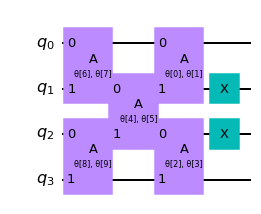

In [6]:
num_parameter = 10
params = ParameterVector('\N{greek small letter theta}', num_parameter)

qr = QuantumRegister(num_site, 'q')
uncomputing_circuit = QuantumCircuit(qr)

uncomputing_circuit.append(make_Agate(params[8], params[9]), qr[2:4])
uncomputing_circuit.append(make_Agate(params[6], params[7]), qr[0:2])
uncomputing_circuit.append(make_Agate(params[4], params[5]), qr[1:3])
uncomputing_circuit.append(make_Agate(params[2], params[3]), qr[2:4])
uncomputing_circuit.append(make_Agate(params[0], params[1]), qr[0:2])

uncomputing_circuit.x(1)
uncomputing_circuit.x(2)

uncomputing_circuit.draw('mpl')

In [7]:
def make_minimizer(target_circuit):
    ansatz = target_circuit.compose(uncomputing_circuit)
    fiscpnp = SequentialVCMinimizer(ansatz, local_cost_function, backend, shots=0, num_experiments=1, default_section=FitGeneral)
    fiscpnp.cost_section_generators[0] = FitSecond
    fiscpnp.cost_section_generators[1] = FitFirst
    fiscpnp.cost_section_generators[2] = FitSecond
    fiscpnp.cost_section_generators[3] = FitFirst
    fiscpnp.cost_section_generators[5] = FitFirst
    
    return fiscpnp

fiscpnp = make_fiscpnp(target_circuits[1])

fiscpnp._conjugate_ansatz().draw('mpl')

#param_val = np.random.rand(len(params)) * 2. * np.pi
param_val = [0.25343321606078595, 1.1006531485103022, 1.7569335439870133, 1.0846072343563011, 1.2343204990201635, 2.2764240198077883, 1.444497290010199, 1.1293928353867044, 1.3714586367166888, 1.1341587498842647]

test_circuit = fiscpnp._make_circuit(param_val, 1, np.pi / 2.)
test_circuit.draw('mpl')

fiscpnp.shots = 0
probs = fiscpnp._run_circuits([test_circuit])
print(probs)

def plot_optimization_result(current, theta_opt, costs, cost_section):
    fig, axes = plt.subplots(1, 1)
    
    thetas_curve = np.linspace(-2. * np.pi, 2. * np.pi, 201)
    plt.plot(thetas_curve, cost_section.fun(thetas_curve))

    plt.scatter(cost_section.thetas, costs)

    plt.scatter([current], [cost_section.fun(current)], c=['g'])
    plt.scatter([theta_opt], [cost_section.fun(theta_opt)], c=['r'])

iparam = 0
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print(type(cost_section))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 1
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 2
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 3
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 4
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 5
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 6
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

print('===SYMMETRIC===')
fiscpnp.cost_section_generators[iparam] = FitSymmetric
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 7
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
print('coeffs', cost_section.coeffs)
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 8
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

exact_gen = fiscpnp.cost_section_generators[iparam]

print('===SYMMETRIC===')
fiscpnp.cost_section_generators[iparam] = FitSymmetric
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

iparam = 9
cost_section, costs = fiscpnp._smo_one_iter(param_val, iparam)
theta_opt = cost_section.minimize()
print('update', param_val[iparam], '->', theta_opt)
print('cost at theta_opt', cost_section.fun(theta_opt))
print('grad at theta', cost_section.grad(param_val[iparam]))
print('update over grad', (theta_opt - param_val[iparam]) / cost_section.grad(param_val[iparam]))
print('coeffs', cost_section.coeffs)
#print('test points', cost_section.thetas)
#print('costs at test points', costs)
plot_optimization_result(param_val[iparam], theta_opt, costs, cost_section)

## Solving RQD

In [8]:
def callback_step(isweep, iparam, sweep_param_val, theta_opt, costs, cost_section):
    print('isweep', isweep, 'iparam', iparam, 'cost', cost_section.fun(theta_opt))
    
def callback_sweep(isweep, param_val, sweep_param_val, mean_cost, sweep_mean_cost):
    print('isweep', isweep, 'update distance', np.max(np.abs(param_val - sweep_param_val)), 'cost', sweep_mean_cost, 'cost update', sweep_mean_cost - mean_cost)
    print('params [' + ', '.join(map(str, sweep_param_val)) + ']')
    
param_values = []

for it, target_circuit in enumerate(target_circuits):
    print('=======', it + 1, 'trotter steps ========')
    fiscpnp = make_minimizer(target_circuit)

    section_gen_switched = False
    def switch_section_gen(isweep, param_val, sweep_param_val, mean_cost, sweep_mean_cost):
        global section_gen_switched

        if section_gen_switched:
            return
        
        if sweep_mean_cost < 0.015:
            print('Switching section generators')
            for iparam in [4, 6, 7, 8, 9]:
                fiscpnp.cost_section_generators[iparam] = FitSymmetric
                
            section_gen_switched = True
    
    initial_param_val = np.ones(len(params), dtype='f8') * np.pi / 4.
    #initial_param_val = np.zeros(len(params), dtype='f8')
    param_val, cost_values, nexp = fiscpnp.minimize(initial_param_val, callbacks_step=[callback_step], callbacks_sweep=[callback_sweep, switch_section_gen], gradient_descent_threshold=-0.1)
    print('>>>', nexp, 'experiments')
    param_values.append(param_val)

======= 1 trotter steps ========
isweep 0 iparam 0 cost 0.37064252034221395
isweep 0 iparam 1 cost 0.3691254457565687
isweep 0 iparam 2 cost 0.3550253366824915
isweep 0 iparam 3 cost 0.3535082620968462
isweep 0 iparam 4 cost 0.32343329454638525
isweep 0 iparam 5 cost 0.304931778992388
isweep 0 iparam 6 cost 0.15225427110810535
isweep 0 iparam 7 cost 0.13756588687050864
isweep 0 iparam 8 cost 0.11848532737371853
isweep 0 iparam 9 cost 0.09146908762569461
isweep 0 update distance 5.031274656811988 cost 0.2576441211394921 cost update -0.7423558788605079
params [5.816672820209436, 1.0379674359178486, 1.1042838398247432, 1.0379674359178455, 1.3283320357820112, 1.9212419533671388, 1.3255281836254313, 1.3880851557533032, 0.9876370862082299, 1.2123383641026126]
isweep 1 iparam 0 cost 0.005573451855928446
isweep 1 iparam 1 cost 0.005502423996117247
isweep 1 iparam 2 cost 0.0023649613058287777
isweep 1 iparam 3 cost 0.0023478252195111154
isweep 1 iparam 4 cost 0.0018103964694337615
isweep 1 ipar

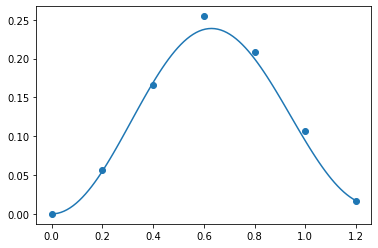

In [11]:
estimator = uncomputing_circuit.inverse()

probs_list_exact = plot_curve(num_site, aJ, am, omegadt * num_tstep)
probs_list = [probs_list_exact[0]]
for param_val in param_values:
    circuit = estimator.assign_parameters(dict(zip(params, param_val)))
    circuit = transpile(circuit, backend=backend)
    probs_list.append((np.square(np.abs(backend.run(circuit).result().data()['statevector'])), 0))
    
densities, _ = number_density(probs_list, num_toys=0)
plt.scatter(np.arange(num_tstep + 1) * omegadt, densities)